[IPython Notebook](rossiter_mclaughlin.ipynb) |  [Python Script](rossiter_mclaughlin.py)

Rossiter-McLaughlin Effect
============================

Setup
-----------------------------

In [1]:
%matplotlib inline

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

Let's make a significant mass ratio and radius ratio...

In [3]:
b['q'] = 0.7

In [4]:
b['requiv@primary'] = 1.0

In [5]:
b['requiv@secondary'] = 0.5

In [6]:
b['teff@secondary@component'] = 5000

Make sure the primary star is spinning quickly...

In [7]:
b['syncpar@primary@component'] = 2

Adding Datasets
-------------------

Now we'll add radial velocity and mesh datasets.  We'll add two identical datasets for RVs so that we can have one computed dynamically and the other computed numerically (these options will need to be set later).

In [8]:
b.add_dataset('rv', times=np.linspace(0,2,201), dataset='dynamicalrvs')  
# TODO: can't set rv_method here because compute options don't exist yet... and that's kind of annoying

<ParameterSet: 15 parameters | contexts: compute, dataset>

In [9]:
b.add_dataset('rv', times=np.linspace(0,2,201), dataset='numericalrvs')

<ParameterSet: 15 parameters | contexts: compute, dataset>

Storing the mesh at every timestep is overkill, and will be both computationally and memory intensive.  So let's just sample at the times we care about.

In [10]:
times = b.get_value('times@primary@numericalrvs@dataset')
times = times[times<0.1]
print times

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


In [11]:
b.add_dataset('mesh', dataset='mesh01', times=times, columns=['vws'])

<ParameterSet: 4 parameters | contexts: compute, dataset>

Running Compute
--------------------

Now let's set the rv_method so that one dataset uses the dynamical method and the other uses the flux-weighted (numerical) method.  Note that here we have to use set_value_all or loop over the components, as technically there are parameters for each component-dataset pair.

In [12]:
b.set_value_all('rv_method@dynamicalrvs@compute', 'dynamical')
b.set_value_all('rv_method@numericalrvs@compute', 'flux-weighted')

Let's check to make sure that rv_method is set as we'd expect.

In [13]:
print b['rv_method']

ParameterSet: 4 parameters
  rv_method@primary@dynamical...: dynamical
  rv_method@secondary@dynamic...: dynamical
  rv_method@primary@numerical...: flux-weighted
  rv_method@secondary@numeric...: flux-weighted


In [14]:
b.run_compute(irrad_method='none')

<ParameterSet: 70 parameters | kinds: rv, mesh>

Plotting 
---------------

Now let's plot the radial velocities.

First we'll plot the dynamical RVs.  Note that dynamical RVs show the true radial velocity of the center of mass of each star, and so we do not see the Rossiter McLaughlin effect.

Mon, 08 Oct 2018 18:55 PARAMETERS   WARNING assuming you meant 'c' instead of 'color'
Mon, 08 Oct 2018 18:55 PARAMETERS   WARNING assuming you meant 'c' instead of 'color'


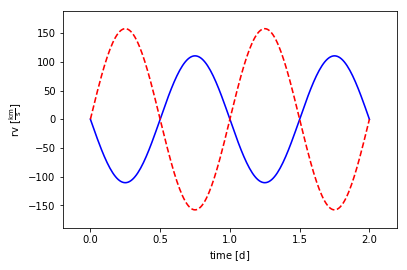

In [15]:
axs, artists = b['dynamicalrvs@model'].plot(component='primary', color='b')
axs, artists = b['dynamicalrvs@model'].plot(component='secondary', color='r', show=True)

But the numerical method integrates over the visible surface elements, giving us what we'd observe if deriving RVs from observed spectra of the binary.  Here we do see the Rossiter McLaughlin effect.  You'll also notice that RVs are not available for the secondary star when its completely occulted (they're nans in the array).

Mon, 08 Oct 2018 18:55 PARAMETERS   WARNING assuming you meant 'c' instead of 'color'
Mon, 08 Oct 2018 18:55 PARAMETERS   WARNING assuming you meant 'c' instead of 'color'


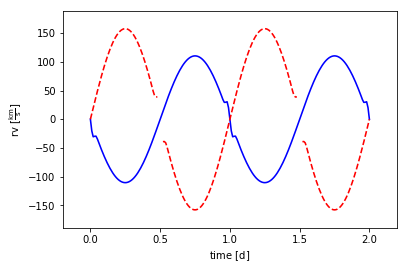

In [16]:
axs, artists = b['numericalrvs@model'].plot(component='primary', color='b')
axs, artists = b['numericalrvs@model'].plot(component='secondary', color='r', show=True)

To visualize what is happening, we can plot the radial velocities of each surface element in the mesh at one of these times.

Here just plot on the mesh@model parameterset - the mesh will automatically get coordinates from mesh01 and then we point to rvs@numericalrvs for the facecolors.

In [17]:
fig = plt.figure(figsize=(12,12))
axs, artists = b['mesh@model'].plot(time=0.03, facecolor='rvs@numericalrvs', edgecolor=None, show=True)

Mon, 08 Oct 2018 18:55 PARAMETERS   WARNING assuming you meant 'fc' instead of 'facecolor'
Mon, 08 Oct 2018 18:55 PARAMETERS   WARNING assuming you meant 'ec' instead of 'edgecolor'


ValueError: could not find Parameter for rvs@numericalrvs

<Figure size 864x864 with 0 Axes>

Here you can see that the secondary star is blocking part of the "red" RVs of the primary star.

This is essentially the same as plotting the negative z-component of the velocities (for convention - our system is in a right handed system with +z towards the viewer, but RV convention has negative RVs for blue shifts).

We could also plot the RV per triangle by plotting 'vws'.  Note that this is actually defaulting to an inverted colormap to show you the same colorscheme ('RdBu_r' vs 'RdBu').

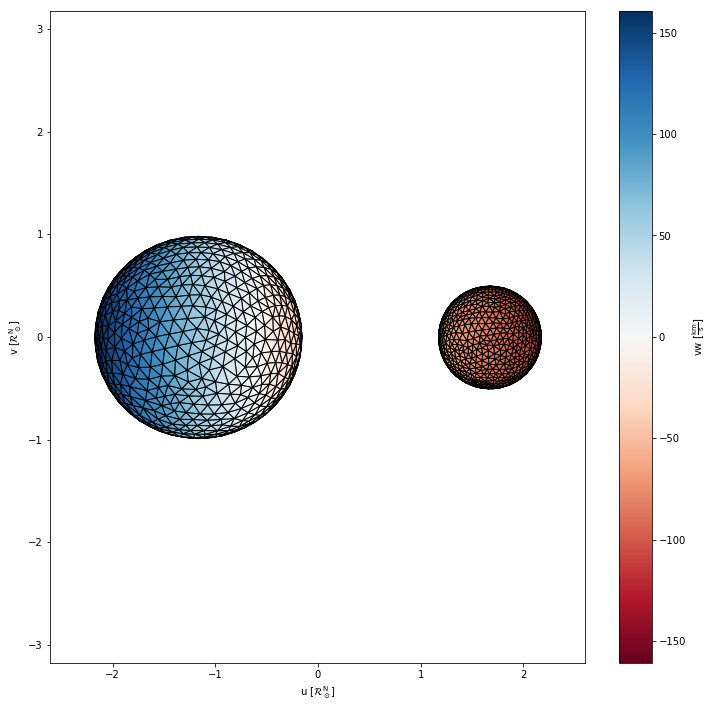

In [18]:
fig = plt.figure(figsize=(12,12))
axs, artists = b['mesh01@model'].plot(time=0.09, fc='vws', ec=None, show=True)